# Exercise 07.2 - Implementing ResNet

Before you can start, you have to find a GPU on the system that is not heavily used by other users. Otherwise you cannot initialize your neural network.


**Hint:** the command is **nvidia-smi**, just in case it is displayed above in two lines because of a line break.

As a result you get a summary of the GPUs available in the system, their current memory usage (in MiB for megabytes), and their current utilization (in %). There should be six or eight GPUs listed and these are numbered 0 to n-1 (n being the number of GPUs). The GPU numbers (ids) are quite at the beginning of each GPU section and their numbers increase from top to bottom by 1.

Find a GPU where the memory usage is low. For this purpose look at the memory usage, which looks something like '365MiB / 16125MiB'. The first value is the already used up memory and the second value is the total memory of the GPU. Look for a GPU where there is a large difference between the first and the second value.

**Remember the GPU id and write it in the next line instead of the character X.**

In [1]:
# Change X to the GPU number you want to use,
# otherwise you will get a Python error
# e.g. USE_GPU = 4
USE_GPU = 4 # YOUR CHOICE

### Choose one GPU

**The following code is very important and must always be executed before using TensorFlow in the exercises, so that only one GPU is used and that it is set in a way that not all its memory is used at once. Otherwise, the other students will not be able to work with this GPU.**

The following program code imports the TensorFlow library for Deep Learning and outputs the version of the library.

Then, TensorFlow is configured to only see the one GPU whose number you wrote in the above cell (USE_GPU = X) instead of the X.

Finally, the GPU is set so that it does not immediately reserve all memory, but only uses more memory when needed. 

(The comments within the code cell explains a bit of what is happening if you are interested to better understand it. See also the documentation of TensorFlow for an explanation of the used methods.)

In [2]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow version: 2.3.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:4 GPU


# Residual Networks


**In this exercise, you will:**
Implement the established ResNet50 architecture which can be used for predictions with  a pre-trained weights. 
The ResNet-50 model consists of 5 stages each with a `Convolution and Identity block`. Each convolution block has 3 convolution layers and each identity block also has 3 convolution layers. The ResNet-50 has over 23 million trainable parameters. For this reason, you will not train your network. 


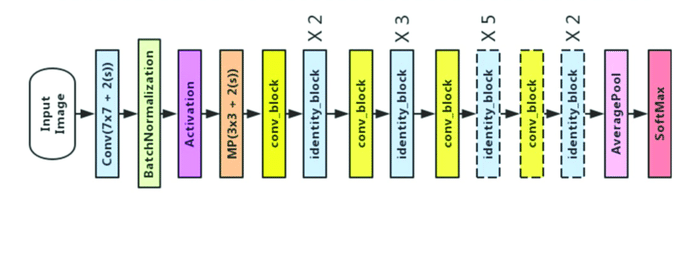


For this you will use [tensorflow keras functional API](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model).

Your tasks include:
- Implementation of basic building blocks of ResNets. 
- Assambling   these building blocks to implement state-of-the-art neural network for image classification. Due to the high computation requirements you will not train this network. Nevertheless also only building the model is a very useful exercise in working with the Functional API.

Load the required packages.

In [3]:
%matplotlib inline
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')

## 1 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the gradient to be directly backpropagated to earlier layers:  

<img src="images/ResNet_skip_connections.png" style="width:600px;height:200px;">
<caption> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Input's path in ResNet without and with Skip connections** </caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

We also saw in lecture that having `ResNet block`s with the `skip connections` also makes it very easy for one of the blocks to learn an `identity function`. This means that you can stack on additional ResNet blocks with little risk of harming training set performance. 


`Two main types of blocks` are used in a `ResNet`, depending mainly on whether the _input/output dimensions are same or different_. You are going to implement both of them. 

### TASK 1: Building an Identity Block

Implement the `ResNet identity block` in the body of the function written below.
The component layers that form the `ResNet identity block` are described in the next notebook cell.

As an example, the first component of the main path was implemented. Please read over this carefully to make sure you understand what it is doing. You should implement the rest. 
- To implement the Conv2D step: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Conv2D)
- To implement BatchNormalization: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the channels axis))
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Add)

<center><img src="images/Identity_block.png" style="width:650px;height:150px;"></center>
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Identity block.** Skip connection "skips over" 3 layers.</center></caption>

**First module of main path:**
- The first `CONV2D` has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2a'`. Use 0 as the seed for the random initialization.
- The first BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Second module of main path:**
- The second `CONV2D` has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same" and its name should be `conv_name_base + '2b'`. Use 0 as the seed for the random initialization.
- The second BatchNorm is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

**Third component of main path:**
- The third `CONV2D` has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be `conv_name_base + '2c'`. Use 0 as the seed for the random initialization.
- The third `BatchNorm` is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is **no ** `ReLU activation function` in this component. 

**Final step:** 
- The shortcut and the input are added together. To add the two inputs you should use a [tensorflow keras merge operation](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Add) 
- Then apply the ReLU activation function. This has no name and no hyperparameters. 

In [4]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block 
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = -1, name = bn_name_base + '2c')(X)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = X + X_shortcut
    X = Activation('relu')(X)
   
    
    
    return X

#### TASK 2: The convolutional block
Implement the convolutional block in the body of the function written below.
The component layers that form the `ResNet convolutional block` are described in the next notebook cell.
As before, always use 0 as the seed for the random initialization.


The ResNet **"convolutional block"** is the other type of block.  The difference with the identity block is that **there is a `CONV2D layer` in the shortcut path**. That's why you can use this type of block when the input and output dimensions don't match up.

<center><img src="images/canv_block.png" style="width:850px;height:150px;"></center>
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **ResNet convolutional block** </center></caption>

The _CONV2D_ layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.  For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. **Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.**


The details of the convolutional block are as follows. 

**First component of main path:**
- The first `CONV2D` has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '2a'`. 
- The first `BatchNorm` is normalizing the channels axis.  Its name should be `bn_name_base + '2a'`.
- Then apply the `ReLU` activation function. This has no name and no hyperparameters. 

**Second component of main path:**
- The second `CONV2D` has $F_2$ filters of ($f$,$f$) and a stride of (1,1). Its padding is "same" and it's name should be `conv_name_base + '2b'`.
- The second `BatchNorm` is normalizing the channels axis.  Its name should be `bn_name_base + '2b'`.
- Then apply the `ReLU` activation function. This has no name and no hyperparameters. 

**Third component of main path:**
- The third `CONV2D` has $F_3$ filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be `conv_name_base + '2c'`.
- The third `BatchNorm` is normalizing the channels axis.  Its name should be `bn_name_base + '2c'`. Note that there is no `ReLU` activation function in this component. 

**Shortcut path:**
- The `CONV2D` has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be `conv_name_base + '1'`.
- The `BatchNorm` is normalizing the channels axis.  Its name should be `bn_name_base + '1'`. 

**Final step:**
- Add together the shortcut and the main path values 
- Then apply the `ReLU` activation function. This has no name and no hyperparameters. 
    


In [5]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure above.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding= 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (1, 1), strides = (1,1), padding= 'valid', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, (1, 1), strides = (1,1), padding= 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding= 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)  # please pay attention which is the input to which you apply this function/layer

 

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = X + X_shortcut
    X = Activation('relu')(X)
    
  
    
    return X

### Task 3:  Building your first ResNet model (50 layers)
Implement the ResNet with 50 layers described in the figure below. The  Stages 1 and 2 are already implemented. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2.) Make sure you follow the _naming convention_ in the text below. 


You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<center><img src="images/04_ResNEt50.png" style="width:880px;height:200px;"></center>
<caption><center> <u> <font color='purple'> **Figure 4** </u><font color='purple'>  : **ResNet-50 model** </center></caption>


The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    - BatchNorm is applied to the channels axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    - The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
- Stage 3:
    - The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    - The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
- Stage 4:
    - The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    - The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
- Stage 5:
    - The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    - The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
- The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
- The flatten doesn't have any hyperparameters or name.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be `'fc' + str(classes)`.


You'll need to use this function: 
- Average pooling [see reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/AveragePooling2D)

Here're some other functions we used in the code below:
- Conv2D: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/ZeroPadding2D)
- Max pooling: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully conected layer: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/layers/Add)

In [6]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL ->
    -> CONVBLOCK -> IDBLOCK*2 ->
    -> CONVBLOCK -> IDBLOCK*3 ->
    -> CONVBLOCK -> IDBLOCK*5 ->
    -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input) # required by ResNet
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')


    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL. Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name='avg_pooling')(X)
    


    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [7]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

### References 

This notebook presents the ResNet algorithm due to He et al. (2015). The implementation here also took significant inspiration and follows the structure given in the github repository of Francois Chollet: 

- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun - [Deep Residual Learning for Image Recognition (2015)](https://arxiv.org/abs/1512.03385)